# Metrics to calculate:
- % stabilized overall
- % stabilied high severity
- % stabilized low severity
- % stabilized liver
- % stabilized spleen
- % time MAP safe (map_violations / total episode time * 100%)
- mean time to death (only for episodes ending in death (HR) or failed to advance)
- mean time to stabilization (only for episodes ending in stabilization)
- mean total blood and total cryst per episode (separate high and low severity episodes)
- mean cryst and blood rate (separate high/low sev eps) - fluid rate = total fluid / episode length

In [3]:
import sys
import os

script_dir = script_dir = os.getcwd()
parent_dir = os.path.dirname(script_dir)
sys.path.append(parent_dir)

import pandas as pd
import numpy as np

In [7]:
def calc_bootstrap_outcomes(df, n_boot=1000, ci=95):
    values = df['outcome'].values
    n = len(values)

    boot_stats = [] # list of stabilization rates from each bootstrap sample
    for _ in range(n_boot):
        sample = np.random.choice(values, size=n, replace=True)
        boot_stats.append(np.mean(sample) * 100)

    lower = np.percentile(boot_stats, (100 - ci) / 2)
    upper = np.percentile(boot_stats, 100 - (100 - ci) / 2)

    return np.mean(boot_stats), lower, upper

In [8]:
def calc_stable_stats(df):
    assert(df.iloc[0].id == 0 and df.iloc[-1].id == 49)
    df['outcome'] = (df['outcome'] == "stabilization").astype(int)
    df_highsev = df.iloc[:25, :]
    df_lowsev = df.iloc[25:, :]
    df_liver = df[df['organ']=="liver"]
    df_spleen = df[df['organ']=="spleen"]

    overall = calc_bootstrap_outcomes(df)
    highsev = calc_bootstrap_outcomes(df_highsev)
    lowsev = calc_bootstrap_outcomes(df_lowsev)
    liver = calc_bootstrap_outcomes(df_liver)
    spleen = calc_bootstrap_outcomes(df_spleen)
    return overall, highsev, lowsev, liver, spleen

In [49]:
def calc_bootstrap_time_to_end(df, n_boot=1000, ci=95):
    # ignores truncated episodes
    assert(df.iloc[0].id == 0 and df.iloc[-1].id == 49)
    df_death = df[(df['outcome'] == "failed to advance") | (df['outcome'] == "death (HR)")]
    values = df_death['length'].values
    n = len(values)

    boot_stats_death = []
    if len(values) > 0:
        for _ in range(n_boot):
            sample = np.random.choice(values, size=n, replace=True)
            boot_stats_death.append(np.mean(sample))
        lower_death = np.percentile(boot_stats_death, (100 - ci) / 2)
        upper_death = np.percentile(boot_stats_death, 100 - (100 - ci) / 2)
    else:
        lower_death = 0
        upper_death = 0

    df_stable = df[df['outcome'] == "stabilization"]
    values_s = df_stable['length'].values
    n = len(values_s)
    boot_stats_stable = []
    for _ in range(n_boot):
        sample = np.random.choice(values_s, size=n, replace=True)
        boot_stats_stable.append(np.mean(sample))
    lower_stable = np.percentile(boot_stats_stable, (100 - ci) / 2)
    upper_stable = np.percentile(boot_stats_stable, 100 - (100 - ci) / 2)

    return np.mean(boot_stats_death), lower_death, upper_death, np.mean(boot_stats_stable), lower_stable, upper_stable

In [10]:
# % time MAP above safe (map_violations / total episode time * 100%)
def calc_bootstrap_map_violations(df, n_boot=1000, ci=95):
    assert(df.iloc[0].id == 0 and df.iloc[-1].id == 49)

    values = (df['map_violations'] / df['length']).values * 100
    n = len(values)

    boot_stats = [] # list of % time MAP above safe from each bootstrap sample
    for _ in range(n_boot):
        sample = np.random.choice(values, size=n, replace=True)
        boot_stats.append(np.mean(sample))

    lower = np.percentile(boot_stats, (100 - ci) / 2)
    upper = np.percentile(boot_stats, 100 - (100 - ci) / 2)

    return np.mean(boot_stats), lower, upper

In [11]:
# mean total blood and total cryst per episode (separate high and low severity episodes)
# mean cryst and blood rate (separate high/low sev eps) - fluid rate = total fluid / episode length
def calc_booostrap_fluid_rate(df, n_boot=1000, ci=95):
    assert(df.iloc[0].id == 0 and df.iloc[-1].id == 49)

    # high severity
    df_highsev = df.iloc[:25, :]

        # blood
    values_blood_high = (df_highsev['blood_total'] / df_highsev['length']).values
    n_high = len(values_blood_high)
    boot_stats_blood_high = []
    for _ in range(n_boot):
        sample = np.random.choice(values_blood_high, size=n_high, replace=True)
        boot_stats_blood_high.append(np.mean(sample))
    lower_blood_high = np.percentile(boot_stats_blood_high, (100 - ci) / 2)
    upper_blood_high = np.percentile(boot_stats_blood_high, 100 - (100 - ci) / 2)

        # cryst
    values_cryst_high = (df_highsev['cryst_total'] / df_highsev['length']).values
    n_high = len(values_cryst_high)
    boot_stats_cryst_high = []
    for _ in range(n_boot):
        sample = np.random.choice(values_cryst_high, size=n_high, replace=True)
        boot_stats_cryst_high.append(np.mean(sample))
    lower_cryst_high = np.percentile(boot_stats_cryst_high, (100 - ci) / 2)
    upper_cryst_high = np.percentile(boot_stats_cryst_high, 100 - (100 - ci) / 2)

    # low severity
    df_lowsev = df.iloc[25:, :]

        # blood
    values_blood_low = (df_lowsev['blood_total'] / df_lowsev['length']).values
    n_low = len(values_blood_low)
    boot_stats_blood_low = []
    for _ in range(n_boot):
        sample = np.random.choice(values_blood_low, size=n_low, replace=True)
        boot_stats_blood_low.append(np.mean(sample))
    lower_blood_low = np.percentile(boot_stats_blood_low, (100 - ci) / 2)
    upper_blood_low = np.percentile(boot_stats_blood_low, 100 - (100 - ci) / 2)

        #  cryst
    values_cryst_low = (df_lowsev['cryst_total'] / df_lowsev['length']).values
    n_low = len(values_cryst_low)
    boot_stats_cryst_low = []
    for _ in range(n_boot):
        sample = np.random.choice(values_cryst_low, size=n_low, replace=True)
        boot_stats_cryst_low.append(np.mean(sample))
    lower_cryst_low = np.percentile(boot_stats_cryst_low, (100 - ci) / 2)
    upper_cryst_low = np.percentile(boot_stats_cryst_low, 100 - (100 - ci) / 2)

    return ((np.mean(boot_stats_blood_high), lower_blood_high, upper_blood_high),
            (np.mean(boot_stats_cryst_high), lower_cryst_high, upper_cryst_high),
            (np.mean(boot_stats_blood_low), lower_blood_low, upper_blood_low),
            (np.mean(boot_stats_cryst_low), lower_cryst_low, upper_cryst_low))

In [12]:
# mean total blood and total cryst per episode (separate high and low severity episodes)
# mean cryst and blood rate (separate high/low sev eps) - fluid rate = total fluid / episode length
def calc_booostrap_fluid_use(df, n_boot=1000, ci=95):
    assert(df.iloc[0].id == 0 and df.iloc[-1].id == 49)

    # high severity
    df_highsev = df.iloc[:25, :]

        # blood
    values_blood_high = df_highsev['blood_total'].values
    n_high = len(values_blood_high)
    boot_stats_blood_high = []
    for _ in range(n_boot):
        sample = np.random.choice(values_blood_high, size=n_high, replace=True)
        boot_stats_blood_high.append(np.mean(sample))
    lower_blood_high = np.percentile(boot_stats_blood_high, (100 - ci) / 2)
    upper_blood_high = np.percentile(boot_stats_blood_high, 100 - (100 - ci) / 2)

        # cryst
    values_cryst_high = df_highsev['cryst_total'].values
    n_high = len(values_cryst_high)
    boot_stats_cryst_high = []
    for _ in range(n_boot):
        sample = np.random.choice(values_cryst_high, size=n_high, replace=True)
        boot_stats_cryst_high.append(np.mean(sample))
    lower_cryst_high = np.percentile(boot_stats_cryst_high, (100 - ci) / 2)
    upper_cryst_high = np.percentile(boot_stats_cryst_high, 100 - (100 - ci) / 2)

    # low severity
    df_lowsev = df.iloc[25:, :]

        # blood
    values_blood_low = df_lowsev['blood_total'].values
    n_low = len(values_blood_low)
    boot_stats_blood_low = []
    for _ in range(n_boot):
        sample = np.random.choice(values_blood_low, size=n_low, replace=True)
        boot_stats_blood_low.append(np.mean(sample))
    lower_blood_low = np.percentile(boot_stats_blood_low, (100 - ci) / 2)
    upper_blood_low = np.percentile(boot_stats_blood_low, 100 - (100 - ci) / 2)

        #  cryst
    values_cryst_low = df_lowsev['cryst_total'].values
    n_low = len(values_cryst_low)
    boot_stats_cryst_low = []
    for _ in range(n_boot):
        sample = np.random.choice(values_cryst_low, size=n_low, replace=True)
        boot_stats_cryst_low.append(np.mean(sample))
    lower_cryst_low = np.percentile(boot_stats_cryst_low, (100 - ci) / 2)
    upper_cryst_low = np.percentile(boot_stats_cryst_low, 100 - (100 - ci) / 2)

    return ((np.mean(boot_stats_blood_high), lower_blood_high, upper_blood_high),
            (np.mean(boot_stats_cryst_high), lower_cryst_high, upper_cryst_high),
            (np.mean(boot_stats_blood_low), lower_blood_low, upper_blood_low),
            (np.mean(boot_stats_cryst_low), lower_cryst_low, upper_cryst_low))

In [13]:
df_moe = pd.read_csv(r'C:\Users\michellexu\Pulse\engine\src\python\pulse\rl-hemorrhage-resuscitation\final_system\eval_data_csvs\eval_data_moe.csv')
df_moe = df_moe.iloc[12:, :]
df_moe.head()

,id,organ,severity,gating,patient,outcome,length,blood_total,cryst_total,vp_total,map_violations
12,0,liver,0.4,tensor([1]),C:\Users\michellexu\Pulse\engine\src\python\pu...,stabilization,21,4021.9482,0.0,0.038430,0
13,1,liver,0.2,tensor([1]),C:\Users\michellexu\Pulse\engine\src\python\pu...,stabilization,21,2417.1455,0.0,0.274458,0
14,2,liver,0.3,tensor([1]),C:\Users\michellexu\Pulse\engine\src\python\pu...,stabilization,21,2937.6519,0.0,0.116922,1
15,3,spleen,1.0,tensor([1]),C:\Users\michellexu\Pulse\engine\src\python\pu...,stabilization,28,2464.3760,0.0,0.016637,3
16,4,liver,0.2,tensor([1]),C:\Users\michellexu\Pulse\engine\src\python\pu...,stabilization,21,2257.0930,0.0,0.281032,0


In [14]:
df_moe.iloc[0].id == 0 and df_moe.iloc[-1].id == 49

np.True_

In [15]:
calc_stable_stats(df_moe)

((np.float64(81.862), np.float64(70.0), np.float64(92.0)),
 (np.float64(63.932), np.float64(44.0), np.float64(84.0)),
 (np.float64(100.0), np.float64(100.0), np.float64(100.0)),
 (np.float64(100.0), np.float64(100.0), np.float64(100.0)),
 (np.float64(71.321875), np.float64(53.125), np.float64(84.375)))

In [37]:
calc_bootstrap_time_to_end(df_moe) # np.mean(boot_stats_death), lower_death, upper_death, np.mean(boot_stats_stable), lower_stable, upper_stable

(np.float64(14.53),
 np.float64(8.0),
 np.float64(18.0),
 np.float64(24.638829268292685),
 np.float64(22.463414634146343),
 np.float64(27.342073170731705))

In [38]:
calc_bootstrap_map_violations(df_moe) # np.mean(boot_stats), lower, upper

(np.float64(6.154010394265233),
 np.float64(1.6900435227854582),
 np.float64(11.385294418842806))

In [44]:
calc_booostrap_fluid_use(df_moe) # ((np.mean(boot_stats_blood_high), lower_blood_high, upper_blood_high),
                                 # (np.mean(boot_stats_cryst_high), lower_cryst_high, upper_cryst_high),
                                 # (np.mean(boot_stats_blood_low), lower_blood_low, upper_blood_low),
                                 # (np.mean(boot_stats_cryst_low), lower_cryst_low, upper_cryst_low))

((np.float64(1980.51081439184),
  np.float64(1517.2358533620002),
  np.float64(2427.9361205399996)),
 (np.float64(1701.49361005192),
  np.float64(692.950285002),
  np.float64(3003.4533563960003)),
 (np.float64(399.84210280524405),
  np.float64(56.5238340229),
  np.float64(782.4059125862)),
 (np.float64(1170.9020148220002),
  np.float64(954.4840458799999),
  np.float64(1397.9714700999998)))

In [16]:
calc_booostrap_fluid_rate(df_moe)

((np.float64(80.77859685003958),
  np.float64(60.03357763301217),
  np.float64(100.90129204272935)),
 (np.float64(28.037407178743198),
  np.float64(8.502155264768112),
  np.float64(51.28601648828344)),
 (np.float64(11.6355430903313),
  np.float64(2.6891277967303737),
  np.float64(22.67882419309099)),
 (np.float64(52.62230941181282),
  np.float64(43.451062600305555),
  np.float64(61.27441533653474)))

In [37]:
df_lowsev = pd.read_csv(r'C:\Users\michellexu\Pulse\engine\src\python\pulse\rl-hemorrhage-resuscitation\final_system\eval_data_csvs\eval_data_lowsev.csv')
df_lowsev.iloc[0].id == 0 and df_lowsev.iloc[-1].id == 49


np.True_

In [58]:
df_highsev = pd.read_csv(r'C:\Users\michellexu\Pulse\engine\src\python\pulse\rl-hemorrhage-resuscitation\final_system\eval_data_csvs\eval_data_highsev.csv')
df_highsev.iloc[0].id == 0 and df_highsev.iloc[-1].id == 49

np.True_

In [67]:
df_pid = pd.read_csv(r'C:\Users\michellexu\Pulse\engine\src\python\pulse\rl-hemorrhage-resuscitation\final_system\eval_data_csvs\eval_data_pid.csv')
df_pid.iloc[0].id == 0 and df_pid.iloc[-1].id == 49

np.True_

In [75]:
df_proto = pd.read_csv(r'C:\Users\michellexu\Pulse\engine\src\python\pulse\rl-hemorrhage-resuscitation\final_system\eval_data_csvs\eval_data_prototype.csv')

In [94]:
df_ppo = pd.read_csv(r'C:\Users\michellexu\Pulse\engine\src\python\pulse\rl-hemorrhage-resuscitation\final_system\eval_data_csvs\eval_data_highsev_ppo.csv')

In [298]:
calc_booostrap_fluid_use(df_proto)

((np.float64(8572.547831612),
  np.float64(7376.7761421),
  np.float64(10062.3599179)),
 (np.float64(12243.265286744),
  np.float64(10713.1099324),
  np.float64(14045.2089588)),
 (np.float64(2192.702270204),
  np.float64(1865.0896444),
  np.float64(2584.7115041)),
 (np.float64(3439.359441412),
  np.float64(2966.4946044999997),
  np.float64(4017.296003699999)))

In [299]:
df = pd.read_csv(r'C:\Users\michellexu\Pulse\engine\src\python\pulse\rl-hemorrhage-resuscitation\final_system\feature_ablation\low_sev_expert\csvs\no_skintemp.csv')

In [296]:
calc_stable_stats(df)

((np.float64(39.776), np.float64(26.0), np.float64(54.0)),
 (np.float64(40.184), np.float64(20.0), np.float64(60.0)),
 (np.float64(39.332), np.float64(20.0), np.float64(60.0)),
 (np.float64(27.288888888888888),
  np.float64(11.11111111111111),
  np.float64(50.0)),
 (np.float64(46.865625), np.float64(31.25), np.float64(62.5)))

In [93]:
# ignores truncated episodes
assert(df.iloc[0].id == 0 and df.iloc[-1].id == 49)
df_death = df[(df['outcome'] == "failed to advance") | (df['outcome'] == "death (HR)")]
values = df_death['length'].values
n = len(values)

boot_stats_death = []
if len(values) > 0:
    for _ in range(n_boot):
        sample = np.random.choice(values, size=n, replace=True)
        boot_stats_death.append(np.mean(sample))
    lower_death = np.percentile(boot_stats_death, (100 - ci) / 2)
    upper_death = np.percentile(boot_stats_death, 100 - (100 - ci) / 2)
else:
    lower_death = 0
    upper_death = 0

df_stable = df[df['outcome'] == "stabilization"]
values_s = df_stable['length'].values
n = len(values_s)
boot_stats_stable = []
for _ in range(n_boot):
    sample = np.random.choice(values_s, size=n, replace=True)
    boot_stats_stable.append(np.mean(sample))
lower_stable = np.percentile(boot_stats_stable, (100 - ci) / 2)
upper_stable = np.percentile(boot_stats_stable, 100 - (100 - ci) / 2)
print(np.mean(boot_stats_death), lower_death, upper_death, np.mean(boot_stats_stable), lower_stable, upper_stable)

25.748 18.0 34.55833333333333 28.610219512195123 26.5609756097561 30.684146341463414


In [63]:
df = pd.read_csv(r'C:\Users\michellexu\Pulse\engine\src\python\pulse\rl-hemorrhage-resuscitation\final_system\eval_data_csvs\eval_data_rppo2.csv')
df = df.iloc[-50:, :]
calc_stable_stats(df)

((np.float64(78.122), np.float64(66.0), np.float64(88.0)),
 (np.float64(83.672), np.float64(68.0), np.float64(96.0)),
 (np.float64(72.092), np.float64(55.90000000000001), np.float64(88.0)),
 (np.float64(83.46666666666667),
  np.float64(66.66666666666666),
  np.float64(100.0)),
 (np.float64(74.978125), np.float64(59.375), np.float64(90.625)))

# McNemar's test

In [135]:
pip install statsmodels

   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   --- ------------------------------------ 0.8/9.5 MB 3.7 MB/s eta 0:00:03
   ----- ---------------------------------- 1.3/9.5 MB 4.0 MB/s eta 0:00:03
   -------- ------------------------------- 2.1/9.5 MB 3.3 MB/s eta 0:00:03
   ---------- ----------------------------- 2.6/9.5 MB 3.4 MB/s eta 0:00:03
   ------------- -------------------------- 3.1/9.5 MB 3.1 MB/s eta 0:00:03
   --------------- ------------------------ 3.7/9.5 MB 3.0 MB/s eta 0:00:02
   ------------------ --------------------- 4.5/9.5 MB 3.1 MB/s eta 0:00:02
   --------------------- ------------------ 5.2/9.5 MB 3.2 MB/s eta 0:00:02
   --------------------------- ------------ 6.6/9.5 MB 3.4 MB/s eta 0:00:01
   ------------------------------- -------- 7.6/9.5 MB 3.7 MB/s eta 0:00:01
   ------------------------------------- -- 8.9/9.5 MB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 9.5/9.5 MB 4.0 MB/s  0:00:02

   ------------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [136]:
from statsmodels.stats.contingency_tables import mcnemar

In [195]:
df_moe = pd.read_csv(r'C:\Users\michellexu\Pulse\engine\src\python\pulse\rl-hemorrhage-resuscitation\final_system\eval_data_csvs\eval_data_moe.csv')
df_moe = df_moe.iloc[12:, :]
df_lowsev = pd.read_csv(r'C:\Users\michellexu\Pulse\engine\src\python\pulse\rl-hemorrhage-resuscitation\final_system\eval_data_csvs\eval_data_lowsev.csv')
df_highsev = pd.read_csv(r'C:\Users\michellexu\Pulse\engine\src\python\pulse\rl-hemorrhage-resuscitation\final_system\eval_data_csvs\eval_data_highsev.csv')
#df_highsev = df_highsev.iloc[:25, :]
df_proto = pd.read_csv(r'C:\Users\michellexu\Pulse\engine\src\python\pulse\rl-hemorrhage-resuscitation\final_system\eval_data_csvs\eval_data_prototype.csv')
df_pid = pd.read_csv(r'C:\Users\michellexu\Pulse\engine\src\python\pulse\rl-hemorrhage-resuscitation\final_system\eval_data_csvs\eval_data_pid.csv')
df_ppo = pd.read_csv(r'C:\Users\michellexu\Pulse\engine\src\python\pulse\rl-hemorrhage-resuscitation\final_system\eval_data_csvs\eval_data_highsev_ppo.csv')
df_ppo = df_ppo.iloc[:25, :]

In [196]:
moe_results = df_moe['outcome'] == "stabilization"
proto_results = df_proto['outcome'] == "stabilization"
lowsev_results = df_lowsev['outcome'] == "stabilization"
highsev_results = df_highsev['outcome'] == "stabilization"
pid_results = df_pid['outcome'] == "stabilization"
ppo_results = df_ppo['outcome'] == "stabilization"

In [197]:
moe_results = moe_results.replace({True:1, False:0})
proto_results = proto_results.replace({True:1, False:0})
lowsev_results = lowsev_results.replace({True:1, False:0})
highsev_results = highsev_results.replace({True:1, False:0})
pid_results = pid_results.replace({True:1, False:0})
ppo_results = ppo_results.replace({True:1, False:0})

moe_results = np.array(moe_results)
proto_results = np.array(proto_results)
lowsev_results = np.array(lowsev_results)
highsev_results = np.array(highsev_results)
pid_results = np.array(pid_results)
ppo_results = np.array(ppo_results)
print(highsev_results)
print(moe_results)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1
 0 1 0 1 0 1 1 1 0 1 1 1 1]
[1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


C:\Users\michellexu\AppData\Local\Temp\ipykernel_6780\4155558798.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  moe_results = moe_results.replace({True:1, False:0})
C:\Users\michellexu\AppData\Local\Temp\ipykernel_6780\4155558798.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  proto_results = proto_results.replace({True:1, False:0})
C:\Users\michellexu\AppData\Local\Temp\ipykernel_6780\4155558798.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old

### MoE vs Prototype

In [174]:
both_success = np.sum((moe_results == 1) & (proto_results == 1))
moe_only = np.sum((moe_results == 1) & (proto_results == 0))
proto_only = np.sum((moe_results == 0) & (proto_results == 1))
both_fail = np.sum((moe_results == 0) & (proto_results == 0))

table = [[both_success, moe_only],
         [proto_only, both_fail]]

In [176]:
result = mcnemar(table, exact=True)
print(f"\nMcNemar's test results:")
print(f"Test statistic: {result.statistic}")
print(f"p-value: {result.pvalue}")


McNemar's test results:
Test statistic: 0.0
p-value: 7.62939453125e-06


### RPPO vs PPO

In [185]:
both_success = np.sum((highsev_results == 1) & (ppo_results == 1))
rppo_only = np.sum((highsev_results == 1) & (ppo_results == 0))
ppo_only = np.sum((highsev_results == 0) & (ppo_results == 1))
both_fail = np.sum((highsev_results == 0) & (ppo_results == 0))

table = [[both_success, rppo_only],
         [ppo_only, both_fail]]

In [186]:
result = mcnemar(table, exact=True)
print(f"\nMcNemar's test results:")
print(f"Test statistic: {result.statistic}")
print(f"p-value: {result.pvalue}")


McNemar's test results:
Test statistic: 1.0
p-value: 0.375


### MoE vs Low Severity

In [187]:
both_success = np.sum((moe_results == 1) & (lowsev_results == 1))
moe_only = np.sum((moe_results == 1) & (lowsev_results == 0))
lowsev_only = np.sum((moe_results == 0) & (lowsev_results == 1))
both_fail = np.sum((moe_results == 0) & (lowsev_results == 0))

table = [[both_success, moe_only],
         [lowsev_only, both_fail]]

In [188]:
result = mcnemar(table, exact=True)
print(f"\nMcNemar's test results:")
print(f"Test statistic: {result.statistic}")
print(f"p-value: {result.pvalue}")


McNemar's test results:
Test statistic: 2.0
p-value: 0.453125


### MoE vs High Severity

In [198]:
both_success = np.sum((moe_results == 1) & (highsev_results == 1))
moe_only = np.sum((moe_results == 1) & (highsev_results == 0))
highsev_only = np.sum((moe_results == 0) & (highsev_results == 1))
both_fail = np.sum((moe_results == 0) & (highsev_results == 0))

table = [[both_success, moe_only],
         [highsev_only, both_fail]]

In [199]:
result = mcnemar(table, exact=True)
print(f"\nMcNemar's test results:")
print(f"Test statistic: {result.statistic}")
print(f"p-value: {result.pvalue}")


McNemar's test results:
Test statistic: 7.0
p-value: 1.0


### MoE vs PID

# t-tests

In [200]:
from scipy.stats import ttest_ind

### blood usage b/w MoE and high-sev expert (only stabliized episodes)

In [207]:
moe_successful = df_moe[df_moe['outcome']=="stabilization"]
highsev_successful = df_highsev[df_highsev['outcome']=="stabilization"]
moe_blood = moe_successful['blood_total'].values
highsev_blood = highsev_successful['blood_total'].values

moe_mean = np.mean(moe_blood)
moe_std = np.std(moe_blood)
highsev_mean = np.mean(highsev_blood)
highsev_std = np.std(highsev_blood)

In [208]:
t_stat, p_value = ttest_ind(moe_blood, highsev_blood)
print(f"MoE blood usage (successful episodes): {moe_mean} +- {moe_std:.1f} mL")
print(f"High-sev expert blood usage (successful episodes): {highsev_mean} +- {highsev_std:.1f} mL")
print(f"Difference: {moe_mean - highsev_mean} mL")
print(f"T-statistic: {t_stat}, P-value: {p_value}")

MoE blood usage (successful episodes): 1250.5509117536587 +- 1402.4 mL
High-sev expert blood usage (successful episodes): 1938.0400679999998 +- 804.8 mL
Difference: -687.489156246341 mL
T-statistic: -2.663683294723801, P-value: 0.009364743686882528


In [300]:
moe_successful = df_moe.iloc[:25, :]
highsev_successful = df_proto.iloc[:25, :]
moe_blood = moe_successful['blood_total'].values
highsev_blood = highsev_successful['blood_total'].values

moe_mean = np.mean(moe_blood)
moe_std = np.std(moe_blood)
highsev_mean = np.mean(highsev_blood)
highsev_std = np.std(highsev_blood)
t_stat, p_value = ttest_ind(moe_blood, highsev_blood)
print(f"MoE blood usage (successful episodes): {moe_mean} +- {moe_std:.1f} mL")
print(f"High-sev expert blood usage (successful episodes): {highsev_mean} +- {highsev_std:.1f} mL")
print(f"Difference: {moe_mean - highsev_mean} mL")
print(f"T-statistic: {t_stat}, P-value: {p_value}")

MoE blood usage (successful episodes): 1975.72655628 +- 1244.5 mL
High-sev expert blood usage (successful episodes): 8613.792011999998 +- 3336.0 mL
Difference: -6638.065455719998 mL
T-statistic: -9.133318466776362, P-value: 4.518564706056199e-12


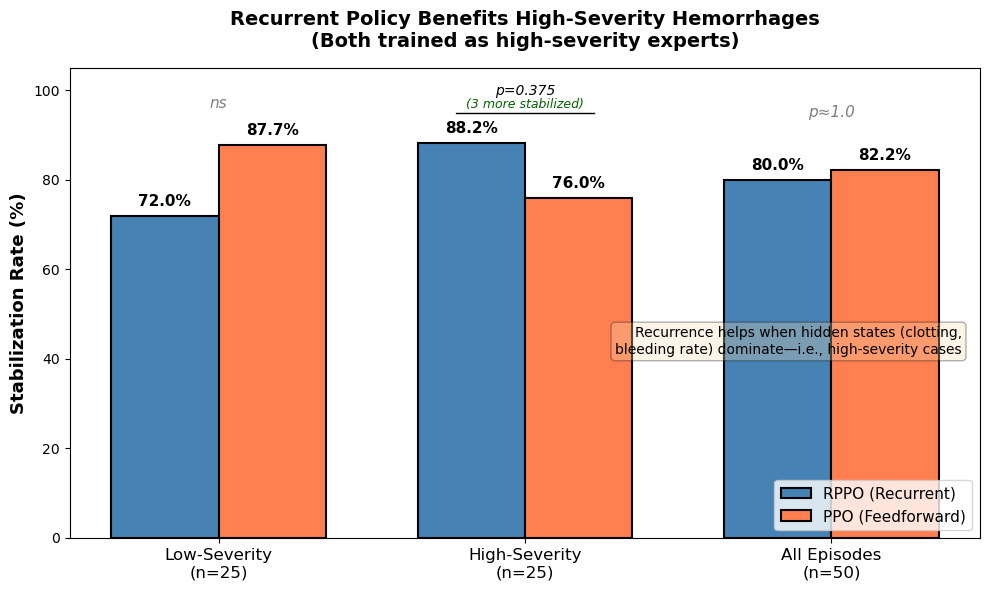

In [223]:
import matplotlib.pyplot as plt
import numpy as np

# Your actual data
categories = ['Low-Severity\n(n=25)', 'High-Severity\n(n=25)', 'All Episodes\n(n=50)']
rppo_rates = [72, 88.2, 80]  # Fill in low-sev and overall
ppo_rates = [87.7, 76.0, 82.2]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, rppo_rates, width, label='RPPO (Recurrent)',
                color='steelblue', edgecolor='black', linewidth=1.5)
rects2 = ax.bar(x + width/2, ppo_rates, width, label='PPO (Feedforward)',
                color='coral', edgecolor='black', linewidth=1.5)

ax.set_ylabel('Stabilization Rate (%)', fontsize=13, fontweight='bold')
ax.set_title('Recurrent Policy Benefits High-Severity Hemorrhages\n(Both trained as high-severity experts)',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=12)
ax.legend(fontsize=11, loc='lower right')
ax.set_ylim([0, 105])

# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

# Add significance annotations
# Low-severity: no difference
ax.text(0, 96, 'ns', ha='center', fontsize=11, style='italic', color='gray')

# High-severity: trend
ax.text(1, 99, 'p=0.375', ha='center', fontsize=10, style='italic')
ax.text(1, 96, '(3 more stabilized)', ha='center', fontsize=9, style='italic', color='darkgreen')
ax.plot([1-width/2-0.05, 1+width/2+0.05], [95, 95], 'k-', linewidth=1)

# Overall: no difference (as expected)
ax.text(2, 94, 'p≈1.0', ha='center', fontsize=11, style='italic', color='gray')

# Add interpretation box
textstr = 'Recurrence helps when hidden states (clotting,\nbleeding rate) dominate—i.e., high-severity cases'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
ax.text(0.98, 0.45, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.savefig('rppo_severity_stratified.png', dpi=300, bbox_inches='tight')
plt.show()